In [1]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pickle, time, gc, copy, sys
import pandas_profiling as pdp
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
# import tensorflow as tf
# AUTOTUNE = tf.data.experimental.AUTOTUNE

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100) # 表示できる表の列数

In [2]:
# trainファイルを読み込む
df_train = pd.read_csv("../input/ai-medical-contest-2021/train.csv")
print("df_train.shape", df_train.shape) # シェイプ = (行数, 列数)を表示する

# testファイルを読み込む
df_test = pd.read_csv("../input/ai-medical-contest-2021//test.csv")
print("df_test.shape", df_test.shape) # シェイプ = (行数, 列数)を表示する

# submissionファイルを読み込む
df_sub = pd.read_csv("../input/ai-medical-contest-2021//sample_submission.csv")
print("df_sub.shape", df_sub.shape) # シェイプ = (行数, 列数)を表示する

# ECGデータのpathの列を追加.
df_train['path'] = df_train['Id'].apply(lambda x: "../input/ai-medical-contest-2021/ecg/{}.npy".format(x))
df_test['path'] = df_test['Id'].apply(lambda x: "../input/ai-medical-contest-2021/ecg/{}.npy".format(x))
print(df_train['path'][0]) # path列の0行目を表示

# trainとtestを連結する
df_traintest = pd.concat([df_train, df_test]).reset_index(drop=True) # reset_index: 行のindexをリセットする
print(df_traintest.shape)

col_target = 'target' # ターゲットの列
col_index = 'Id' # idの列
print("rate of positive: {:.6f}".format(df_train[col_target].mean())) # targetが1である割合

# 各列の基本情報を表示
# 解析対象はtrain+test
# 列名, 型, nanの数, uniqueな値の数, 実際の値の一部, を表示する
df_tmp = df_traintest  # 解析するDataFrameを指定
for i, col in enumerate(df_tmp.columns): # 各列(column)について
    col_name = col + " " * (22 - len(col)) # カラム名, 見た目上の整形のためにスペースを加える
    type_name = "{}".format(df_tmp[col].dtype) # 型名
    type_name = type_name + " " * (8 - len(type_name)) # 見た目上の整形のためにスペースを加える
    num_unique = len(df_tmp[col].unique()) # ユニークな値の数
    num_nan = pd.isna(df_tmp[col]).sum() # nanの数
    col_head = "{}".format(df_tmp[col].unique()[:5].tolist())[:40] # 実際の値の一部
    print("{:4d}: {} dtype: {} unique: {:8d}, nan: {:6d}, 実際の値: {}".format(
        i, col_name, type_name, len(df_tmp[col].unique()), num_nan, col_head)) # 表示する
    
# カテゴリ変数をラベルエンコーディングする (数値に置き換える).
df_traintest['sex'] = df_traintest['sex'].replace('female', 0) # femaleに0を代入
df_traintest['sex'] = df_traintest['sex'].replace('male', 1) # maleに1を代入
df_traintest['sex'] = df_traintest['sex'].astype(int) # 型を整数に変換

df_traintest['label_type'] = df_traintest['label_type'].replace('human', 0) # humanに0を代入
df_traintest['label_type'] = df_traintest['label_type'].replace('auto', 1) # autoに1を代入
df_traintest['label_type'] = df_traintest['label_type'].astype(int) # 型を整数に変換

# train と test を再度切り分ける
df_train = df_traintest.iloc[:len(df_train)]
df_test = df_traintest.iloc[len(df_train):].reset_index(drop=True)

# 全てのECGデータを読み込む
ecg_train = np.zeros([len(df_train), 800, 12], np.float32) # trainの心電図データの代入先. shape=(データ数, 時間方向, 12誘導)
for i in range(len(df_train)): # 全てのtrain dataについて
    path_tmp = df_train['path'][i] # i行目の心電図データのpath
    ecg_tmp = np.load(path_tmp) # i行目の心電図データ
    ecg_train[i] = ecg_tmp # 読み込んだ心電図データをecg_trainのi行目に代入

ecg_test = np.zeros([len(df_test), 800, 12], np.float32) # testの心電図データの代入先. shape=(データ数, 時間方向, 12誘導)
for i in range(len(df_test)): # 全てのtest dataについて
    path_tmp = df_test['path'][i] # i行目の心電図データのpath
    ecg_tmp = np.load(path_tmp) # i行目の心電図データ
    ecg_test[i] = ecg_tmp # 読み込んだ心電図データをecg_trainのi行目に代入
print("ecg_train.shape: {}".format(ecg_train.shape))
print("ecg_test.shape: {}".format(ecg_test.shape))

# target情報をnumpy形式に変換
target_train = df_train[col_target].values.astype(np.int) # pandas.Seriesからnp.ndarrayへ変換
print("target_train.shape: {}".format(target_train.shape))

df_train.shape (2000, 5)
df_test.shape (8000, 4)
df_sub.shape (8000, 2)
../input/ai-medical-contest-2021/ecg/81ac15cb8d3be42e3d0ccdea36176183.npy
(10000, 6)
rate of positive: 0.300000
   0: Id                     dtype: object   unique:    10000, nan:      0, 実際の値: ['81ac15cb8d3be42e3d0ccdea36176183', '92
   1: target                 dtype: float64  unique:        3, nan:   8000, 実際の値: [1.0, 0.0, nan]
   2: age                    dtype: int64    unique:       92, nan:      0, 実際の値: [80, 59, 29, 75, 50]
   3: sex                    dtype: object   unique:        2, nan:      0, 実際の値: ['female', 'male']
   4: label_type             dtype: object   unique:        2, nan:      0, 実際の値: ['human', 'auto']
   5: path                   dtype: object   unique:    10000, nan:      0, 実際の値: ['../input/ai-medical-contest-2021/ecg/8
ecg_train.shape: (2000, 800, 12)
ecg_test.shape: (8000, 800, 12)
target_train.shape: (2000,)


In [3]:
# クロスバリデーションを行うためにデータを5分割する
# 4つを学習に用い、1つを検証に要する。これを5回繰り返す。
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(
    np.arange(len(df_train)), 
    y=df_train[col_target]) # 各foldターゲットのラベルの分布がそろうようにする = stratified K fold
)

# fold 0の学習データと検証データの分割
fold = 0 # fold 0 についての学習を行う

# このfoldにおける学習データと検証データの切り分け
X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
print("X_train.shape: {}, X_valid.shape: {}".format(X_train.shape, X_valid.shape))
print("y_train.shape: {}, y_valid.shape: {}".format(y_train.shape, y_valid.shape))

X_train.shape: (1600, 800, 12), X_valid.shape: (400, 800, 12)
y_train.shape: (1600,), y_valid.shape: (400,)


## Tensorflow(baseline)

# modelにdataを流すためのdatasetを構築する
BATCH_SIZE = 64 # ミニバッチに含めるデータの数
def augment_fn(X, y):
    """
    augmentation (データ水増し)を設定する
    """
    X_new = tf.image.random_crop(X, (700,12)) # 時間方向に800 timepointからrandomに700 timepointを切り出す
    return (X_new, y)
    
# train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(( # np
    X_train, # 入力データ
    y_train, # 正解データ
))
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True) # 学習中にデータをシャッフルすることを指定する
train_dataset = train_dataset.map(augment_fn, num_parallel_calls=AUTOTUNE) # augmentationの適用
train_dataset = train_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する

# valid dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((
    X_valid, # 入力データ
    y_valid, # 正解データ
))
valid_dataset = valid_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する (シャッフルはしない)

# test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    ecg_test, # 入力データ
    np.zeros(len(ecg_test)), # 正解データ (testに正解データないためダミーデータ)
))
test_dataset = test_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する (シャッフルはしない)


# datasetの読み込みテスト
ecg_batch, target_batch = next(iter(train_dataset)) # 試しにミニバッチを読み込む
print("train ecg_batch.shape: {}".format(ecg_batch.shape))
print("train target_batch.shape: {}".format(target_batch.shape))
ecg_batch, target_batch = next(iter(valid_dataset)) # 試しにミニバッチを読み込む
print("valid ecg_batch.shape: {}".format(ecg_batch.shape))
print("valid target_batch.shape: {}".format(target_batch.shape))

# deep learning modelの作成
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
def get_model(input_shape=(800, 12)):
    model = tf.keras.models.Sequential([ # レイヤーのリストからモデルを構築する
        tf.keras.Input(shape=input_shape), # 入力の形状の指定. shape=(時間軸, 12誘導)
        # block1
        tf.keras.layers.Conv1D(64, 7), # 時間方向の1次元畳み込みレイヤー. 32=出力チャネル数, 7=カーネルサイズ
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'), 
        tf.keras.layers.MaxPool1D(2), 
        # block2
        tf.keras.layers.Conv1D(128, 3, strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'), 
        # block3
        tf.keras.layers.Conv1D(256, 3, strides=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # pooling
        tf.keras.layers.GlobalAveragePooling1D(), # 時間方向のglobal pooling
        # 最終レイヤー
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

model = get_model()
model.summary()

# モデルのコンパイル (学習条件の設定)
model = get_model(input_shape=(None, 12)) # 時間軸の入力長さNone=可変にして再度model構築
model.compile(optimizer='adam', # オプティマイザーにAdamを指定
              loss='binary_crossentropy', # 損失関数にbinary crossentropyを指定
              metrics=['AUC'], # 評価関数にAUCを指定
             )
# モデルの保存方法の指定
checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, # 保存path
    save_weights_only=True, # 重みのみを保存
    monitor='val_auc', # validataionのAUCの値に基づいて重みを保存する
    mode='max', # validataionのAUCが最大となった時重みを保存する
    save_best_only=True # AUCが改善したときのみ保存する
)

# fold1-4についても学習を行う
# for loopの中身は上記のfold 0での処理と同様です
for fold in range(5):
    print("fold: {}".format(fold))
    X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
    y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
    print("len train: {}. len valid: {}".format(len(X_train), len(X_valid)))

    # train dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((
        X_train, # 入力データ
        y_train, # 正解データ
    ))
    train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True) # 学習中にデータをシャッフルすることを指定する
    train_dataset = train_dataset.map(augment_fn, num_parallel_calls=AUTOTUNE) # augmentationの適用
    train_dataset = train_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する

    # valid dataset
    valid_dataset = tf.data.Dataset.from_tensor_slices((
        X_valid, # 入力データ
        y_valid, # 正解データ
    ))
    valid_dataset = valid_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する (シャッフルはしない)

    # model構築
    model = get_model(input_shape=(None, 12))
    # モデルのコンパイル (学習条件の設定)
    model.compile(optimizer='adam', # オプティマイザーにAdamを指定
                  loss='binary_crossentropy', # 損失関数にbinary crossentropyを指定
                  metrics=['AUC'], # 評価関数にAUCを指定
                 )
    # モデルの保存方法の指定
    checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, # 保存path
        save_weights_only=True, # 重みのみを保存
        monitor='val_auc', # validataionのAUCの値に基づいて重みを保存する
        mode='max', # validataionのAUCが最大となった時重みを保存する
        save_best_only=True # AUCが改善したときのみ保存する
    )
    # モデルの学習
    model.fit(
        train_dataset, # 学習に用いるdataset
        validation_data=valid_dataset, # 検証に用いるdataset
        callbacks=[model_checkpoint_callback], # モデル保存方法の指定
        epochs=16, # epoch数 (1epoch=すべての画像を1回ずつ学習に利用する)
    )

# クロスバリデーションのAUCを計算する
preds_valid = np.zeros(len(df_train), np.float32) # 予測結果の代入先
for fold in range(5): # 各foldについて
    print("fold: {}".format(fold))
    # valid dataset
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
    valid_dataset = tf.data.Dataset.from_tensor_slices((
        X_valid, # 入力データ
        y_valid, # 正解データ
    ))
    valid_dataset = valid_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する (シャッフルはしない)

    # 予測
    checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
    model.load_weights(checkpoint_filepath) # 最もvalid AUCが高かったエポックの重みを読み込む
    pred_valid = model.predict(valid_dataset) # 予測の実行
    preds_valid[folds[fold][1]] = pred_valid[:,0] # 予測結果の代入

valid_auc = metrics.roc_auc_score(df_train[col_target], preds_valid)
print("CV: {:.6f}".format(valid_auc))

# test dataに対する予測
preds_test = np.zeros([5, len(df_test)], np.float32) # 予測結果の代入先
for fold in range(5): # 各foldについて
    print("fold: {}".format(fold))
    # valid dataset
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
    valid_dataset = tf.data.Dataset.from_tensor_slices((
        X_valid, # 入力データ
        y_valid, # 正解データ
    ))
    valid_dataset = valid_dataset.batch(BATCH_SIZE) # データセットをミニバッチ化してモデルに入力することを指定する (シャッフルはしない)

    # 予測
    checkpoint_filepath = "weight_fold{}.ckpt".format(fold)
    model.load_weights(checkpoint_filepath) # 最もvalid AUCが高かったエポックの重みを読み込む
    pred_test = model.predict(test_dataset) # 予測の実行
    preds_test[fold] = pred_test[:,0] # 予測結果の代入
print("preds_test.shape: {}".format(preds_test.shape))
print(preds_test)

### submitファイルを作成
preds_test_mean = preds_test.mean(axis=0) # 各foldのmodelの予測の平均値を最終的な予測結果として採用する
print("preds_test_mean.shape: {}".format(preds_test_mean.shape))
df_sub[col_target] = preds_test.mean(axis=0) # 推定結果を代入
df_sub.to_csv("submission.tf.csv", index=None) # submitファイルを保存
df_sub.head() # 最初の5行を表示

## pytorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score

from tqdm import tqdm_notebook as tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
input_size = 700

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        super().__init__()
        
        self.data = data
        self.label = label
        self.len = data.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        out_data = self.data
        out_data = out_data[index]

        start_idx = np.random.randint(0,800-input_size-1)
        out_data = out_data[start_idx:start_idx+input_size:,:]
        out_label = self.label[index]
        
        return out_data, out_label

In [6]:
class Net1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128,256,kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256,1)


    def forward(self,x):
#         s1, s2, s3 = x.shape
#         x = x.reshape(s1, s3, s2)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = x.view(-1)

        return x

In [7]:
# https://github.com/eddymina/ECG_Classification_Pytorch/blob/master/ECG_notebook.ipynb

import torch.nn as nn
import torch.nn.functional as F

print("""\nA 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.\n""")

class Anomaly_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Anomaly_Classifier, self).__init__()
    
        self.conv= nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5,stride=1)
        
        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5,stride=1,padding=2)
        self.drop_50 = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool1d(kernel_size=5,stride=2) 

#         self.dense1 = nn.Linear(32 * 8, 32) 
        self.dense1 = nn.Linear(1280, 32) 
        self.dense2 = nn.Linear(32, 32) 
        
        self.dense_final = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        residual= self.conv(x)
      
        #block1 
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x+= residual 
        x = F.relu(x)
        residual = self.maxpool(x) #[512 32 90]
       
        #block2
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 43]
        
        
        #block3
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 20]
        
        
        #block4
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        x= self.maxpool(x) #[512 32 8]
        
        s1, s2, s3 = x.shape
        
        #MLP
        x = x.view(-1, s2 * s3) #Reshape (current_dim, 32*2)
#         print(x.shape)
        
        x = F.relu(self.dense1(x))
        #x = self.drop_60(x)
        x= self.dense2(x)
        x = self.dense_final(x)
        x = x.view(-1)
        return x


A 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.



In [8]:
model = Net1D()
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(total_params)

Net1D(
  (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(2,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
129857


In [23]:
cv = 0
n_splits = 5
optimizer_name = 'Adam'
lr = 0.001
EPOCHS=30

list_weights = []
best_preds_list = []
valid_label_list = []
for fold in range(n_splits):
    X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
    y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
    
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_valid = torch.FloatTensor(X_valid).to(device)
    y_valid = torch.FloatTensor(y_valid).to(device)

    dataset = MyDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    
    dataset_val = MyDataset(X_valid, y_valid)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)

#     model = Net1D().cuda()
    model = Anomaly_Classifier(num_classes= 1).to(device)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    best_auc = 0
    for e in range(EPOCHS):
        avg_loss = 0
        model.train()
        for i, (data, y_target) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred, y_target)
            loss.backward()
            optimizer.step()
        
            avg_loss += loss.item() / len(dataloader)

        model.eval()
        avg_val_loss = 0.
        valid_labels = []
        preds = []
        with torch.no_grad():
            for i, (data, y_target) in enumerate(dataloader_val):
                y_pred = model(data)
                valloss = criterion(y_pred, y_target)
                avg_val_loss += valloss.item() / len(dataloader_val)
                valid_labels.append(y_target.to('cpu').numpy())
                preds.append(F.sigmoid(y_pred).cpu().numpy())
        preds = np.concatenate(preds)
        valid_labels = np.concatenate(valid_labels)
        val_auc = roc_auc_score(valid_labels,preds[:])    

        if e % 1 == 0:
            print('E {}: train loss: {} val loss: {} val AUC: {}'.format(
                e, avg_loss, avg_val_loss, val_auc))

        if best_auc < val_auc:
            best_auc = val_auc
            best_preds = preds
            print(f'  Epoch {e} - Save Best AUC: {best_auc:.4f}')
            best_weight = model.state_dict()

    list_weights.append(best_weight)
    best_preds_list.append(best_preds)
    valid_label_list.append(valid_labels)
    
## calc oof
best_preds_list = np.concatenate(best_preds_list)
valid_label_list = np.concatenate(valid_label_list)
oof_auc = roc_auc_score(valid_labels,preds[:]) 
print(f"OOF_AUC{oof_auc}")

E 0: train loss: 0.5456686675548553 val loss: 0.4652821251324245 val AUC: 0.8388690476190476
  Epoch 0 - Save Best AUC: 0.8389
E 1: train loss: 0.3752699881792069 val loss: 0.3131308172430311 val AUC: 0.9252083333333334
  Epoch 1 - Save Best AUC: 0.9252
E 2: train loss: 0.3079521864652634 val loss: 0.2848109432629176 val AUC: 0.9379761904761904
  Epoch 2 - Save Best AUC: 0.9380
E 3: train loss: 0.27661573618650437 val loss: 0.2944299408367702 val AUC: 0.946547619047619
  Epoch 3 - Save Best AUC: 0.9465
E 4: train loss: 0.27404529035091396 val loss: 0.23896477477891107 val AUC: 0.9548214285714286
  Epoch 4 - Save Best AUC: 0.9548
E 5: train loss: 0.24106124222278594 val loss: 0.24516976518290384 val AUC: 0.9544345238095238
E 6: train loss: 0.25626758694648744 val loss: 0.3515859970024654 val AUC: 0.9516071428571429
E 7: train loss: 0.2405832973122597 val loss: 0.2486893619809832 val AUC: 0.9522619047619048
E 8: train loss: 0.2084369659423829 val loss: 0.24258463297571456 val AUC: 0.9590

In [16]:
preds_test = np.zeros([n_splits, len(df_test)], np.float32) # 予測結果の代入先
for fold, w in tqdm(enumerate(list_weights)):
#     model = Anomaly_Classifier(input_size=12, num_classes= 1).to(device)
    list_test = []

    X_test = torch.FloatTensor(ecg_test).to(device)

    dataset_test = MyDataset(X_test, np.zeros(X_test.shape[0]))
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=False)

#     model = Net1D().to(device)
    model = Anomaly_Classifier(num_classes= 1).to(device)
    model.load_state_dict(w)
    model.eval()
    l_p = []
    with torch.no_grad():
        for i, (data, y_target) in enumerate(dataloader_test):
            y_p = model(data)
            y_p = F.sigmoid(y_p).cpu().numpy()
            l_p.append(y_p)
    y_pred = np.concatenate(l_p)
    preds_test[fold] = y_pred

0it [00:00, ?it/s]

In [17]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

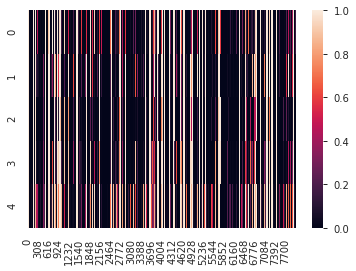

In [18]:
sns.heatmap(preds_test)

In [19]:
### submitファイルを作成
preds_test_mean = preds_test.mean(axis=0) # 各foldのmodelの予測の平均値を最終的な予測結果として採用する
print("preds_test_mean.shape: {}".format(preds_test_mean.shape))
df_sub[col_target] = preds_test.mean(axis=0) # 推定結果を代入
# df_sub[col_target] = preds_test[4]
df_sub.to_csv("submission.torch.csv", index=None) # submitファイルを保存
df_sub.head() # 最初の5行を表示

preds_test_mean.shape: (8000,)


,Id,target
0,eee45832964560ae45040cbc95a252e7,0.033232
1,6a9adde92c964bd844ddeb12bf559130,0.818206
2,ee1f947df169cbdc8569a6959913c4ef,0.001048
3,611df0e51c4fcc5fd1a03887b031a2dc,0.036655
4,2aeae75bd1d6c3ad42574b68d4daf07c,0.844270
